In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sgn

In [3]:
data=pd.read_excel("oscar4mins.xlsx", parse_dates=True)

In [4]:
data

,Original,Filtered
0,928,432.8
1,940,432.8
2,939,439.6
3,947,442.2
4,948,447.4
...,...,...
819,972,499.0
820,953,464.4
821,933,445.0
822,920,427.8


Original


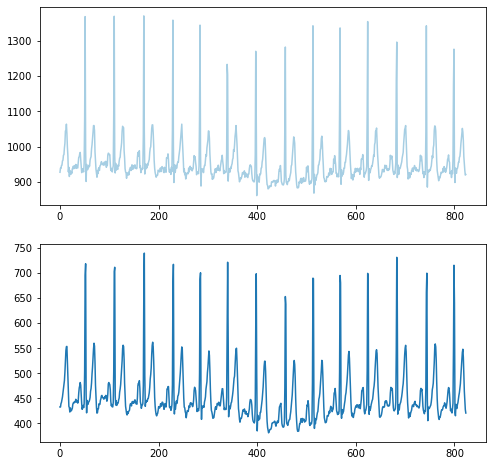

Filtered


In [5]:
fig,axes=plt.subplots(2 , 1, figsize=(8,8))
for i,ax in enumerate(axes.flatten()):
    y=data.iloc[0:1700,i].values
    ax.plot(y,color=plt.cm.Paired(i/10.))
print("Original")

plt.show()
print("Filtered")

## For each level of signal to visualize 100 waves

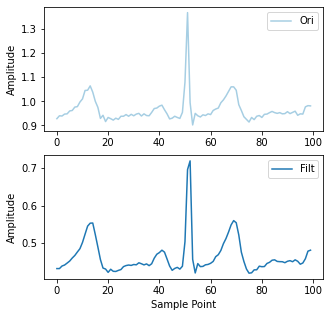

In [6]:
fig,axes=plt.subplots(2, 1 , figsize=(5,5))
leads=['Ori','Filt']
for i,ax in enumerate(axes.flatten()):
    y=data.iloc[0:100,i].values
    y=y/1000
    ax.plot(y,color=plt.cm.Paired(i/10.),label=leads[i])
    axes[i].set_ylabel('Amplitude')
    plt.xlabel('Sample Point')
    axes[i].legend()
plt.show()


## For visualizing 100 to 500 values

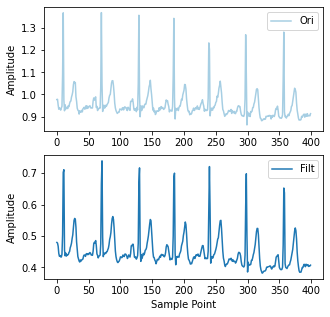

In [7]:
fig,axes=plt.subplots(2, 1 , figsize=(5,5))
leads=['Ori','Filt']
for i,ax in enumerate(axes.flatten()):
    y=data.iloc[100:500,i].values
    y=y/1000
    ax.plot(y,color=plt.cm.Paired(i/10.),label=leads[i])
    axes[i].set_ylabel('Amplitude')
    plt.xlabel('Sample Point')
    axes[i].legend()
plt.show()

## For visualizing 500 to 1000 values

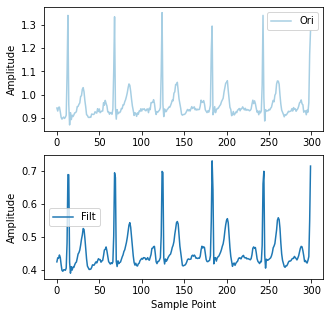

In [8]:
fig,axes=plt.subplots(2, 1 , figsize=(5,5))
leads=['Ori','Filt']
for i,ax in enumerate(axes.flatten()):
    y=data.iloc[500:800,i].values
    y=y/1000
    ax.plot(y,color=plt.cm.Paired(i/10.),label=leads[i])
    axes[i].set_ylabel('Amplitude')
    plt.xlabel('Sample Point')
    axes[i].legend()
plt.show()

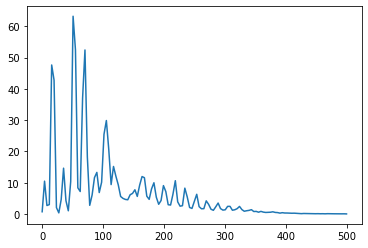

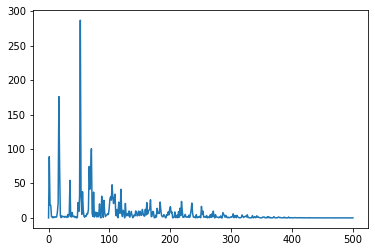

In [9]:
x = data['Filtered']
fs = 1000

# Generate time vector
t = np.arange(len(x))*1/fs

# Compute welch periodogram
freq, Pxx = sgn.welch(x, fs)
#compute periodogram
f1,pxx=sgn.periodogram(x,fs)

#show plots
plt.figure(1)
plt.plot(freq,Pxx)
plt.figure(2)
plt.plot(f1,pxx)


In [10]:
# Function for notch filter Design 
def iirnotch(w0, bw, ab=3):
    """
    Design second-order IIR notch digital filter.

    Parameters
    ----------
    w0 : float
        A scalar that must satisfy  0 < w0 < 1. For
        notch filters, w0 is the normalized frequency 
        to remove from the filtered signal (w0 = 1 
        corresponds to half of the sample frequency).
    bw : float
        Filter bandwidth.
    ab : float, optional
        Atenuation in decibels. By default, `ab`
        is 3. So the atenuation is -3 dB or -10*log10(1/2) dB.

    Returns
    -------
    b, a : ndarray, ndarray
        Numerator (`b`) and denominator (`a`) polynomials
        of the IIR filter.
        
    Notes
    -----
    The quality factor (Q factor) for the filter is related to the 
    filter bandwidth by Q = w0/bw (for the default value of `ab`).
    
    References
    ----------
    .. [1] Sophocles J. Orfanidis, "Introduction To Signal Processing",
           Prentice-Hall, 1996
    """
 # Normalize inputs
    bw = bw*np.pi
    w0 = w0*np.pi

    # Compute atenuation from ab
    gb = 10.0**(-ab/20.0)

    # Compute beta
    beta = (np.sqrt(1.0-gb**2.0)/gb)*np.tan(bw/2.0)

    # Compute gain
    gain = 1.0/(1.0+beta)

    # Compute numerator (`b`) and denominator (`a`):
    b = gain*np.array([1.0, -2.0*np.cos(w0), 1.0])
    a = np.array([1.0, -2.0*gain*np.cos(w0), (2.0*gain-1.0)])

    return (b, a)

Frequency response
Given a sampling frequency of
 the frequency response of a notch filter to eliminate the de component is shown below for a quality factor.

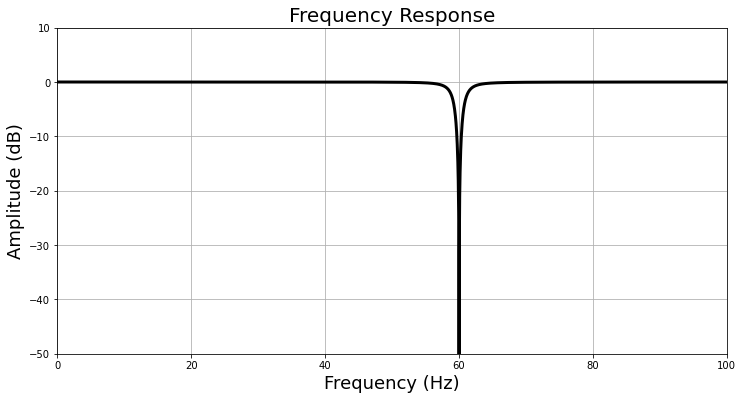

In [11]:
fs = 1000.0  # Hz
f0 = 60.0  # Hz
q = 30.0  # Quality factor

w0 = f0/(fs/2)
bw = w0/q

# Design notch filter
b, a = iirnotch(w0, bw)

# Frequency response
w, h = sgn.freqz(b, a, 2**14)

# Generate frequency axis
freq = w*fs/(2*np.pi)

#plot
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(freq, 20*np.log10(abs(h)), color='black', linewidth=3)
ax.grid()
ax.set_title("Frequency Response", fontsize=20)
ax.set_ylabel("Amplitude (dB)", fontsize=18)
ax.set_xlabel("Frequency (Hz)", fontsize=18)
ax.axis([0, 100, -50, 10])
plt.show()

Application on the ECG signal
To ensure that there is no distortion in the phase, bidirectional filtering will be used (filtfilt function).

Both looking at the periodogram and the signal, it is possible to see that the component of was eliminated from the signal. Despite this, high frequency components still contaminate the signal, they will be discussed in subsequent sections.

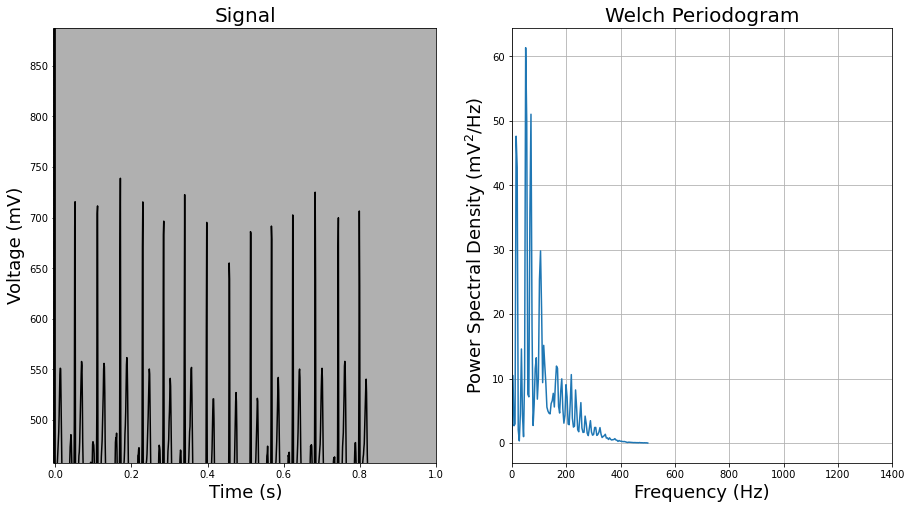

<Figure size 432x288 with 0 Axes>

In [12]:
# Apply notch filter to the signal
x_notch  = sgn.filtfilt(b, a, x)

# Compute welch periodogram
freq, Pxx_notch = sgn.welch(x_notch, fs)

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t[1:1000])
ax[0].plot(t[1:1000], x_notch[1:1000], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
ax[0].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
ax[0].grid(which='minor')
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, Pxx_notch)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].set_xlim([0, 1400])

#show figures
#show signal
plt.figure(1)
plt.show()
#show welch
plt.figure(2)
plt.show()



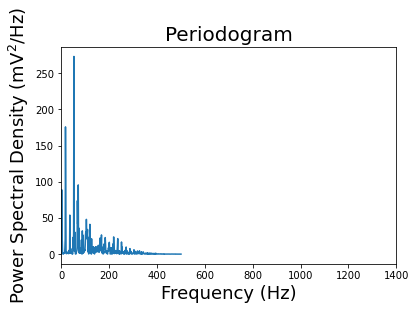

<Figure size 432x288 with 0 Axes>

In [13]:
#plot periodogram
fq, pxx=sgn.periodogram(x_notch,fs)
plt.plot(fq, pxx)
plt.title("Periodogram", fontsize=20)
plt.ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
plt.xlabel("Frequency (Hz)", fontsize=18)
plt.xlim([0, 1400])

#show periodogram
plt.figure(3)
plt.show()

In [14]:
def incrementalestfilter(x, w0, delta=0.00125):
    """
    Apply adaptative non-linear filter to signal `x`
    in order to remove the normalized frequency `w0`

    Parameters
    ----------
    x : array_like
        An one dimensional array containing the signal
        to be filtered.
    w0 : float
        A scalar that must satisfy  0 < w0 < 1,
        w0 is the normalized frequency to remove 
        from the filtered signal (w0 = 1 corresponds
        to half of the sample frequency).
    delta : float
        increment parameter. By default delta = 0.00125.
    
    Returns
    -------
    y : array_like
        The filtered output, an array with the same shape as x.
    
    References
    ----------
    .. [1] Mortara, David W. "Digital filters for ECG signals." 
           Computers in Cardiology (1977): 511-514
    """
# Make sure x is a numpy array 
    x = np.asarray(x, np.float)

    # Initialize output y and auxiliar variables
    y = np.zeros(x.shape)
    w = np.zeros(x.shape)
    e = np.zeros(x.shape)
    v = np.zeros(x.shape)

    # Apply filter
    for n in range(2, len(x)):
        v[n] = 2*np.cos(np.pi*w0)*w[n-1] - w[n-2]
        e[n] = (x[n] - v[n]) - (x[n-1] - w[n-1])
        w[n] = v[n] + delta * np.sign(e[n])
        y[n] = x[n] - w[n]

    return y

Application on the ECG signal. Below is the result of applying the adaptive filter to this signal. Note that the frequency of has been attenuated, but not completely removed.

<ipython-input-14-c8dedb39f970>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.asarray(x, np.float)


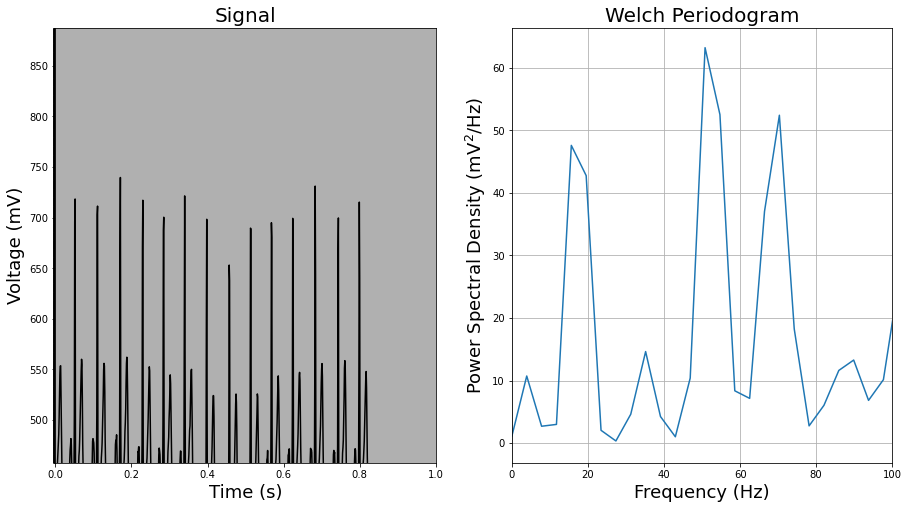

In [15]:
# Apply notch filter to the signal
x_inc  = incrementalestfilter(x, w0, 0.00125)
# Compute welch periodogram
freq, Pxx_inc = sgn.welch(x_inc, fs)

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t[1:1000])
ax[0].plot(t[1:1000], x_inc[1:1000], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
ax[0].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
ax[0].grid(which='minor')
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, Pxx_inc)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].set_xlim([0, 100])

plt.show()

Comparison of methods- the notch filter and the adaptive filter to the electrocardiogram signal.  For 60Hz

The results obtained by simulation seem to indicate that the use of notch filters can obtain a greater attenuation of the noise of , although, according to (Macfarlane et al., 1989) the adaptive filter would be able to obtain better transient responses.

Low Frequency Fluctuations ("Baseline Wander")
Another common source of electrocardiogram distortion is low-frequency fluctuations, usually caused by respiratory movements or by varying the impedance of the electrodes. The frequency of these fluctuations are usually less than. The method that will be studied here to remove these low-frequency oscillations will be the application of high-pass IIR filters.

Example: The figure generated below shows, on the left, an electrocardiogram contaminated by low-frequency fluctuations and, on the right, an estimate for the spectral power density of the signal (using the Welch periodogram).

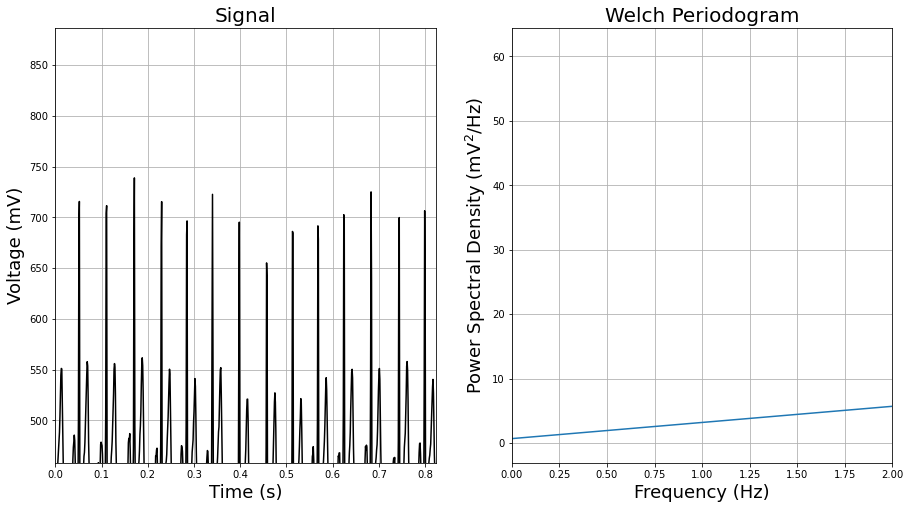

In [16]:
# Get signal from the previous example
x = x_notch

# Compute welch periodogram
freq, Pxx = sgn.welch(x, fs)

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t)
ax[0].plot(t, x, 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, Pxx)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].set_xlim([0,2])

plt.show()

High Pass Filter


a) Frequency response-
A high pass filter is a filter that attenuates low frequencies. As mentioned in the previous section, the low frequency fluctuations that contaminate the electrocardiogram are usually contained between and . To filter these fluctuations an elliptical order filter will be used, it has the following specifications:

Rejection band: frequencies below: 0.4Hz

Passband: frequencies above: 0.2Hz

Attenuation in the rejection band:-4dB

Ripple in the passband:0.1dB

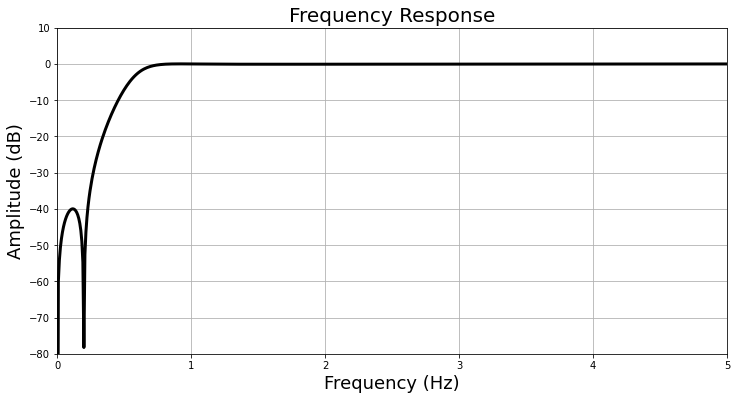

In [17]:
fs = 1000.0  # Hz
fc = 0.8 # Hz, cutoff frequency
fst = 0.2 # Hz, rejection band
rp = 0.1 # dB, ripple in passband
rs = 40 # dB, attenuation in rejection band

wn = fc/(fs/2) # normalized frequency
wst = fst/(fs/2)

filterorder, aux = sgn.ellipord(wn, wst, rp, rs)

# Design high pass filter
b, a = sgn.iirfilter(filterorder, wn, rp, rs, btype='high', ftype='ellip', output='ba')

# Frequency response
w, h = sgn.freqz(b, a, 2**16)

# Generate frequency axis
freq = w*fs/(2*np.pi)

#plot
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(freq, 20*np.log10(abs(h)), color='black', linewidth=3)
ax.grid()
ax.set_title("Frequency Response", fontsize=20)
ax.set_ylabel("Amplitude (dB)", fontsize=18)
ax.set_xlabel("Frequency (Hz)", fontsize=18)
ax.axis([0, 5, -80, 10])
plt.show()

b) Application on the ECG signal

Below is the result of applying the high pass filter to the ECG signal. On the left side is the original signal and on the left side is the signal after the low frequencies have been removed.

It is important to note that bidirectional filtering (filtfilt function) was used. This has two consequences:

The attenuation obtained will be double that for which the filter was designed, since the filter is applied in the forward and reverse directions.
There will be no phase distortion.

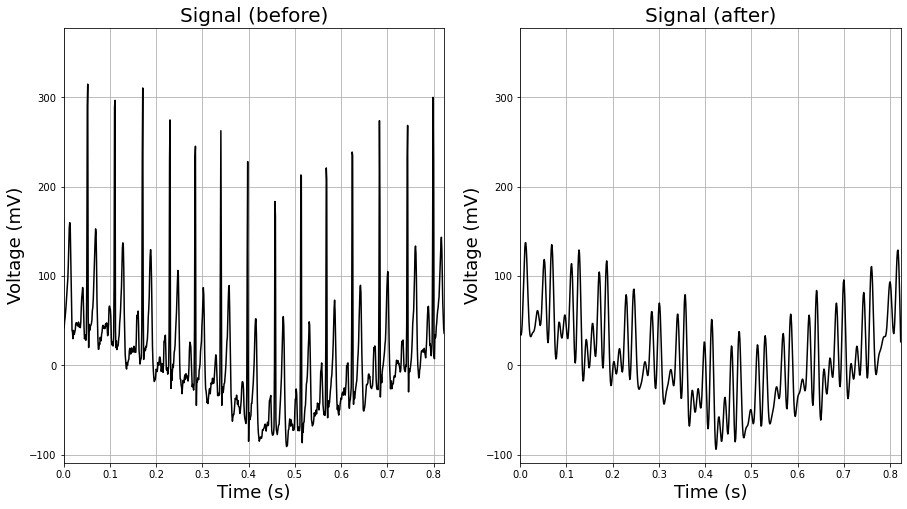

In [47]:
# Apply notch filter to the signal
x_hp  = sgn.filtfilt(b, a, x)
# Compute welch periodogram
freq, Pxx_hp = sgn.welch(x_hp, fs)

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t)
ax[0].plot(t, x, 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal (before)", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].grid()

# Plot welch periodogram
ax[1].plot(t, x_hp, 'k')
ax[1].set_ylabel("Voltage (mV)", fontsize=18)
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[1].set_title("Signal (after)", fontsize=20)
ax[1].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[1].grid()

plt.show()

High Frequency Noise

The electrocardiogram, like so many other electrical signals, is normally contaminated by high-frequency noise. According to the IEC specifications the required bandwidth of the ECG signal is 0.5Hz up to 150Hz.

That way, frequencies above 150Hz can be filtered out to improve signal quality. In fact, as we will show below, the electrocardiogram signal can be filtered with a lower cutoff frequency than 150Hz. On the one hand, this will lower the noise level of the signal, but on the other hand, it will interfere with signal characteristics that can be used for diagnostics (this effect will be studied below).

Electrocardiograms of patients with a pacemaker may show spikes with a frequency higher than 150Hz . These normally must be detected before low pass filtering.

Example: In the generated figure below, an electrocardiogram is shown on the left and an estimate for the spectral power density of the signal (using the Welch periodogram) on the right. Note that although most of the spectral power is contained below 50Hz there are some high frequency components, which are mostly noise components.

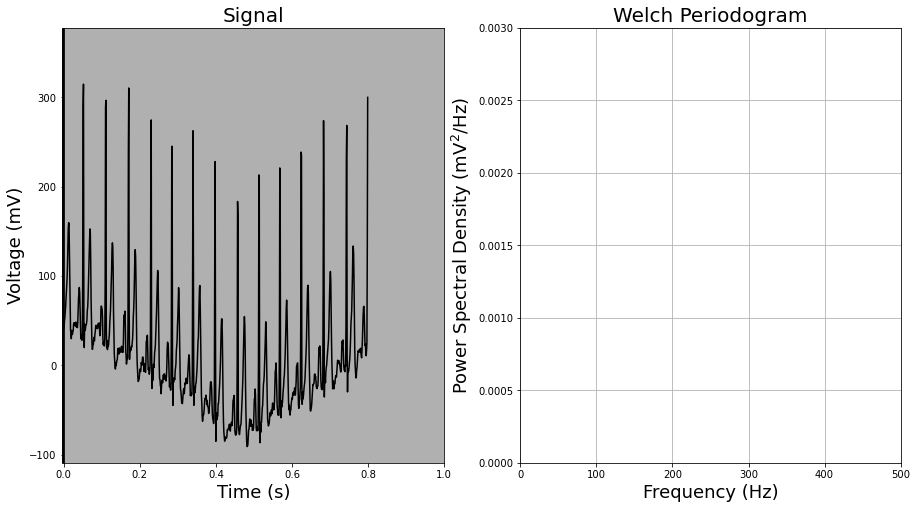

In [19]:
# Get signal from the previous example
x = x_hp

# Compute welch periodogram
freq, Pxx = sgn.welch(x, fs)

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t[1:1000])
ax[0].plot(t[1:800], x[1:800], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
ax[0].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
ax[0].grid(which='minor')
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, 10*Pxx)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].axis([0, 500, 0, 0.003])

plt.show()

Low Pass Filter-

To eliminate this high frequency noise, the application of a low-pass filter will be studied. The IEC specification requires a bandwidth of for the electrocardiogram. For analysis purposes, we will compare the application of three different filters: a filter with a cutoff frequency of 150Hz(in black), a filter with a cutoff frequency of 100Hz(in green ) and a filter with a cutoff frequency of 70Hz(in red ).

a) Frequency response
The frequency response of the filters mentioned above is shown below.

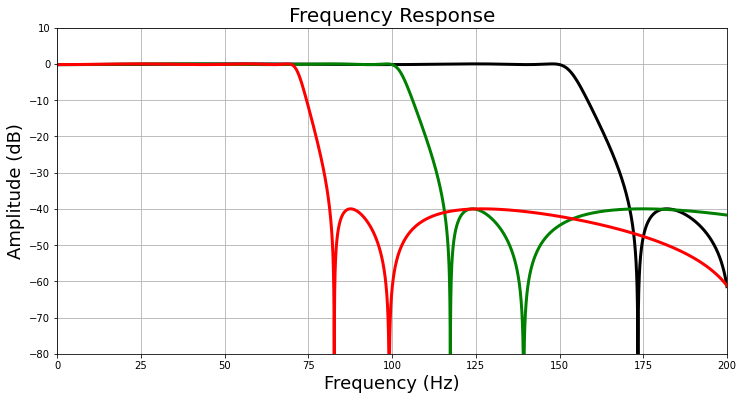

In [20]:
lowpass_cutoff_freq = [150, 100, 70]
color = ["black", "green", "red"]
fig, ax = plt.subplots(1,1, figsize=(12, 6))
b_coef = []
a_coef = []
for i, fc in enumerate(lowpass_cutoff_freq):
    fs = 1000.0  # Hz
    #fc  Hz, cutoff frequency
    fst = fc+0.2*fc # Hz, rejection band
    rp = 0.2 # dB, ripple in passband
    rs = 40 # dB, attenuation in rejection band

    wn = fc/(fs/2) # normalized frequency
    wst = fst/(fs/2)

    filterorder, aux = sgn.ellipord(wn, wst, rp, rs)
    
    # Design lowpass filter
    b, a = sgn.iirfilter(filterorder, wn, rp, rs, btype='low', ftype='ellip', output='ba')

    # save coeficients
    b_coef.append(b)
    a_coef.append(a)
    
    # Frequency response
    w, h = sgn.freqz(b, a, 2**16)

    # Generate frequency axis
    freq = w*fs/(2*np.pi)

    #plot

    ax.plot(freq, 20*np.log10(abs(h)), color=color[i], linewidth=3)
    if i == 0:
        ax.grid()
        ax.set_title("Frequency Response", fontsize=20)
        ax.set_ylabel("Amplitude (dB)", fontsize=18)
        ax.set_xlabel("Frequency (Hz)", fontsize=18)
        ax.axis([0, 200, -80, 10])
    
plt.show()

b) Application on the ECG signal

Filtering, using each of three different cutoff frequencies, is shown below. It is important to note that, again, bidirectional filtering was used to avoid phase distortion.

Some comments on the signal filtered using the low-pass filter for the three specified cutoff frequencies:

1. The lower the cutoff frequency, the greater the noise attenuation. It is easy to verify that the signal filtered with the cutoff frequency filter of 70Hz (in red) is significantly less "hairy" than the signal filtered with the filter of 150Hz(in black).

2. Some signal characteristics of interest are attenuated when the cutoff frequency is less than 150Hz. For example, the peak of the R wave which is for the filtered signal with the filter of 150Hz(in black) has decreased to 1.36mV (a variation of approximately 3%) when we consider the other two signals in green and in red . In this case this effect is not significant, however, in other cases, components significant to the diagnosis may be hidden.

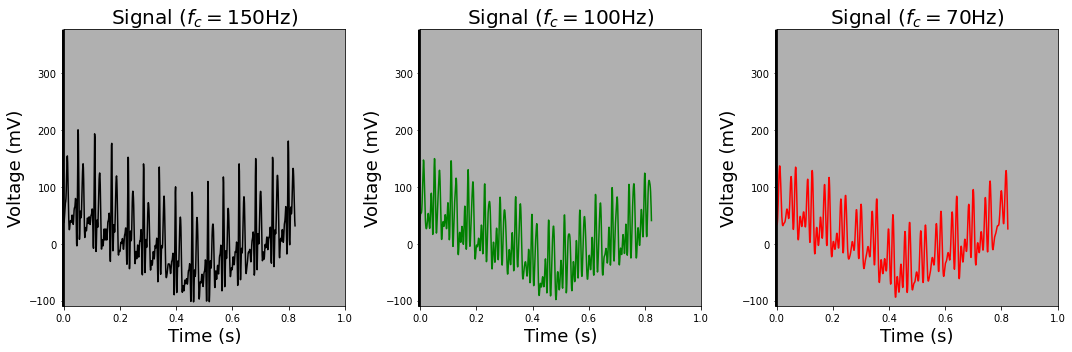

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
tmax = max(t[:1000])


for i, fc in enumerate(lowpass_cutoff_freq):
    # Apply lowpass filter to the signal
    
    x_lp  = sgn.filtfilt(b_coef[i], a_coef[i], x)
    
    # Plot signal
    ax[i].plot(t[:1000], x_lp[:1000],  color=color[i])
    ax[i].set_ylabel("Voltage (mV)", fontsize=18)
    ax[i].set_xlabel("Time (s)", fontsize=18)
    ax[i].set_title("Signal ($f_c ="+str(fc)+"$Hz)", fontsize=20)
    ax[i].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
    ax[i].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
    ax[i].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
    ax[i].grid(which='minor')
    ax[i].grid()

plt.tight_layout()
plt.show()

The spectral content of the ECG is concentrated between 0.5Hz and 150Hz. Note that in this frequency range, the gain grows almost linearly with frequency. 

In this way, the QRS complex, which has higher frequencies, will be enhanced while the other ECG waves are attenuated.

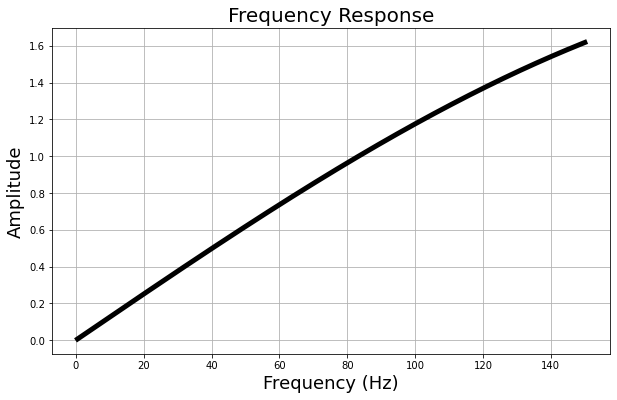

In [22]:
# Generate frequecy grid
f = np.linspace(0.5, 150, 2048)
fs = 1000

omega = f*2*np.pi/fs

# Generate frequency response
freq_resp = 2*abs(np.sin(omega))

# plot
plt.figure(figsize=(10, 6))
plt.plot(f, freq_resp, color='black', linewidth=5)
plt.axis('tight')
plt.title("Frequency Response", fontsize=20)
plt.xlabel("Frequency (Hz)", fontsize=18)
plt.ylabel("Amplitude", fontsize=18)
plt.grid()
plt.show()

In [23]:
def central_diff(x):
    """
    Apply celtral diference to signal x[n].
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing the signal to be processed.
    
    Returns
    -------
    d : array_like
        One dimensional signal with the same dimensions of x, result from
        first difference : d[n] = x[n+1]-x[n-1]
    """
    
    # Length x
    N = len(x)

    # diff
    diff = np.zeros(N)

    # Aproximate first diference fs/2*(x[t+1]-x[t-1])
    for t in range(1, N-1):
        diff[t] = (x[t+1]-x[t-1])

    return diff

def hilbert_transform(x):
    """
    Apply Hilbert transform to signal x[n]
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing the signal to be processed.
         Returns
    -------
    y : array_like
        One dimensional signal with the same dimensions of x, result from
        apply hilbert transform to x.
    """
    
    return np.imag(sgn.hilbert(x))

Next, the procedure for enhancing the QRS complex will be applied to a real electrocardiogram signal. 

Below are shown the sign x[n] , the difference of this sign,d[n] , and finally the result of the Hilbert transform, y[n] . Note that for the signal y[n] ,the QRS complex is highlighted while the P wave is attenuated. 

This prevents the peak of the R wave from being confused with a high-amplitude P wave, for example.

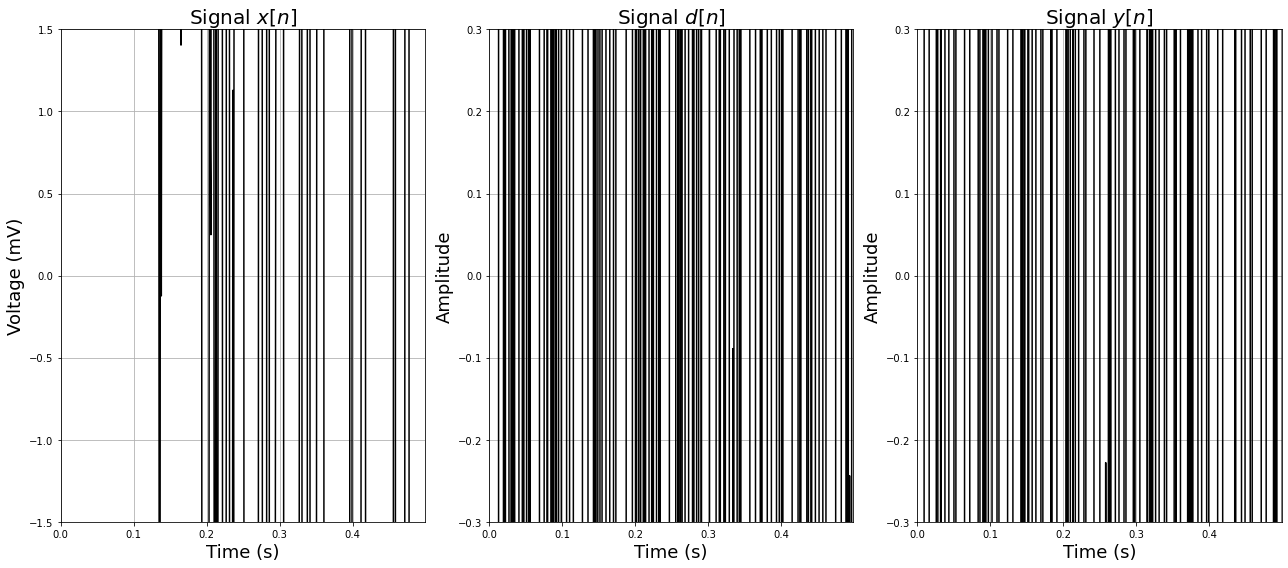

In [24]:
# Apply central diference
d = central_diff(x)

# Apply hilbert transform
y = hilbert_transform(d)

# Plot signal
fig, ax = plt.subplots(1, 3, figsize=(18, 8))
tmax = max(t[1:500])
ax[0].plot(t[1:800], x[1:800], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal $x[n]$", fontsize=20)
ax[0].axis([0, tmax, -1.5, 1.5])
ax[0].grid()
ax[1].plot(t[1:800], d[1:800], 'k')
ax[1].set_ylabel("Amplitude", fontsize=18)
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[1].set_title("Signal $d[n]$", fontsize=20)
ax[1].axis([0, tmax, -0.3, 0.3])
ax[1].grid()
ax[2].plot(t[1:800], y[1:800], 'k')
ax[2].set_ylabel("Amplitude", fontsize=18)
ax[2].set_xlabel("Time (s)", fontsize=18)
ax[2].set_title("Signal $y[n]$", fontsize=20)
ax[2].grid()
ax[2].axis([0, tmax, -0.3, 0.3])

plt.tight_layout()
plt.show()

R peak detection

a) Procedure
The signal y[n] , where the QRS complex is highlighted, will be used to help detect the R peaks. The procedure used follows these steps:

Step One: Find the peaks in the function y[n]. These peaks must be greater than a minimum amplitude 'm' and must respect a minimum distance 'l' between them. The implementation that was used to detect the signal peaks is similar to matlab's findpeaks function y[n] and can be found at http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb.

Step Two: The region around the identified peaks of y[n] is the likely region for the peaks of R.
 the moment of occurrence of a peak at y[n]. The peak of R in will be contained in the interval (n0-E<= n<=n0+E).
 The peak of R will be the largest peak in that range.
 

Below is implemented a function that finds the peaks of R given the highlighted signal y[n] and the original signal x[n]

In [25]:
def find_Rpeaks(x, y, interval, minimum_peak_height, minimum_peak_distance):
    """
    Find R Peaks using enhanced signal.
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing the original ECG signal.
    y : array_like
        One dimensional array containing the signal with enhanced QRS complex.
    minimum_peak_height : float
        Minimum height the signal $y$ should have to be considered a R peak
    minimum_peak_distance : float
        Minimum distance between R peaks
    inteval : float
        Maximum distance to look for a R peak (on x) near an peak an y peak
        
    Returns
    -------
    Rpeaks : array_like
        List containing the R peaks positions on x
    ypeaks : array_like
        List containing the peaks positions on y
    """
    
    # step 1)  Look for peaks on y[n]
    ypeaks = detect_peaks(y, mph=minimum_peak_height, mpd=minimum_peak_distance)
    
    # step 2) Look for R peaks near the ones founds for y[n]
    
    # Fill with NaNs the positions of a new array
    x_near_ypeaks = np.full(x.shape, np.nan);
    
    # Fill only positions near the y peaks
    for p in ypeaks:
        x_near_ypeaks[p-interv:p+interv] = x[p-interv:p+interv]
        
    # detect only peaks near y peaks
    Rpeaks = detect_peaks(x_near_ypeaks)
    
    return Rpeaks, ypeaks

The procedure described above is illustrated below in two figures. The first one shows the peaks detected for the signal y[n]. The following figure shows the R peaks detected in x[n].

The parameters used are written below as a function of the sampling frequency ( fs=1000Hz)

               parameters                 description                             value
                l              minimum distance between peaks in y[n]            0.2fs
                
                m              minimum peak height at y[n]                       0.1
                
                E              minimum distance between maximum peaks in         0.03fs
                                   y[n] and x[n]

In [26]:
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

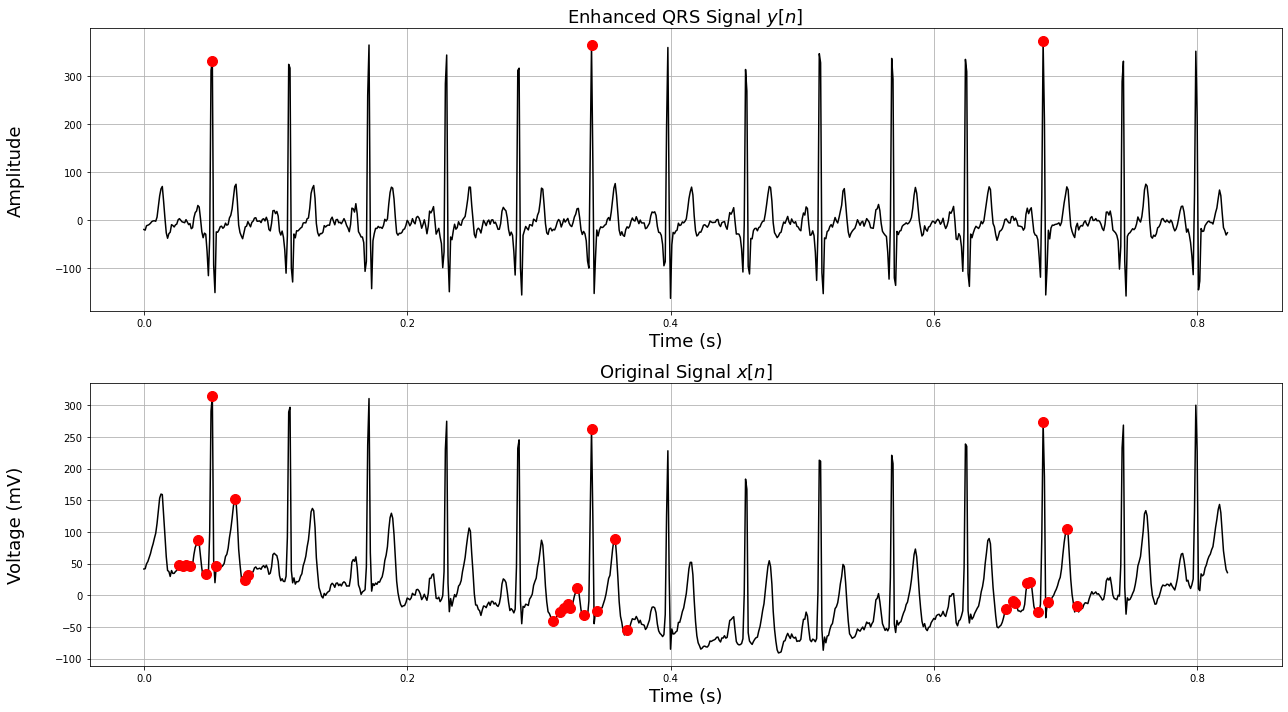

In [27]:

# Parameters for Peak detection
minimum_peak_height = 0.1;
minimum_peak_distance = 0.2*fs
interv  = int(0.03*fs)

# Find R peaks
Rpeaks, ypeaks = find_Rpeaks(x, y, interv, minimum_peak_height, minimum_peak_distance)

# Plot
fig, ax = plt.subplots(2, 1,figsize=(18,10))
ax[0].plot(t, y, 'k')
for p in ypeaks:
    ax[0].plot(t[p], y[p], 'ro', markersize=10)
ax[0].set_ylabel("Amplitude", fontsize=18, labelpad=30)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Enhanced QRS Signal $y[n]$ ", fontsize=18)
ax[0].grid()

ax[1].plot(t, x, 'k')
for p in Rpeaks:
    ax[1].plot(t[p], x[p], 'ro', markersize=10)
ax[1].set_ylabel("Voltage (mV)", fontsize=18, labelpad=30)
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[1].set_title("Original Signal $x[n]$", fontsize=18)
ax[1].grid()
plt.tight_layout()
plt.show()

This procedure proposed by "D. Benitez et. al., "The use of the Hilbert transform in ECG signal analysis", Computers in Biology and Medicine (2001): 399-406" is much more robust than simply looking for the peaks of the R wave in the original signal. 

It avoids confusing the R wave with high amplitude P and T waves. To exemplify this, below is an example of an ECG with high amplitude T waves and the respective R peaks found (correctly!) by the algorithm described above.

High frequency noise will also be amplified by this method along with the QRS complex. So if the electrocardiogram signal is too corrupted with high frequency noise this method may have problems. Despite this, for a well done ECG, high frequency noise levels will not be an issue.

In the book, the author of the procedure reports a very high success rate in the MIT-BIH database, which many ECG feature extraction articles use as a benchmark.

Finally, a serious problem of this method proposed is that it is extremely dependent on parameters m,l andE . These parameters are chosen in a completely empirical way and the optimal value of these values can vary considerably if we consider two different sets of data. We will consider a more robust method of determining these parameters below.

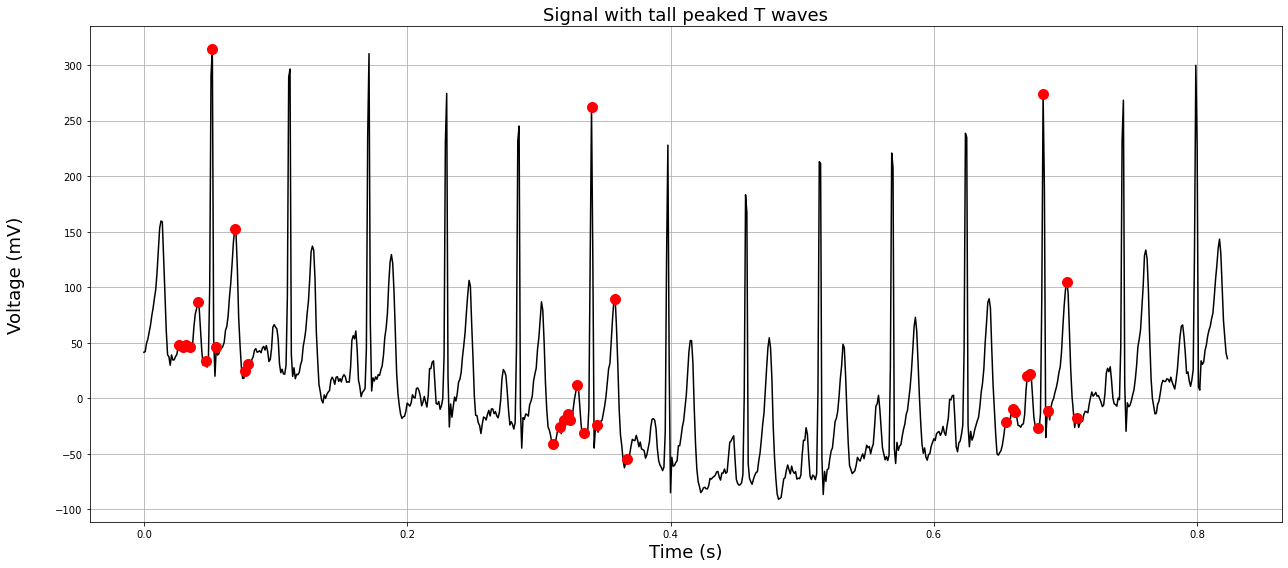

In [28]:
d_ = central_diff(x)
y_ = hilbert_transform(d_)

# Generate time vector
t_= np.arange(len(x))*1/fs

# Find R peaks
Rpeaks_, ypeaks_ = find_Rpeaks(x, y_, interv, minimum_peak_height, minimum_peak_distance)

# plot
fig, ax = plt.subplots(1, 1,figsize=(18,8))
ax.plot(t_, x, 'k')
for p in Rpeaks_:
    ax.plot(t_[p], x[p], 'ro', markersize=10)
ax.set_ylabel("Voltage (mV)", fontsize=18, labelpad=30)
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_title("Signal with tall peaked T waves", fontsize=18)
ax.grid()

plt.tight_layout()
plt.show()

Autocorrelation Sequence

Let X[n] be a stationary signal in the broad sense, the autocorrelation sequence is defined as:

                    r xx[m]=E{X[n]X[n+m]}


In [29]:
def crosscorr(y1, y2, M, normalize=False, numSTD=1.96):
    """ Compute the Cross-Correlation Sequence (CCS) r[m] 
    between two time series y1[n] and y2[n] for -M<=m<=M.
    
    Parameters
    ----------
    y1, y2 : array_like
        One dimensional array containing the two observed time series.
    M : int
        Number of lags the crosscorrelation returns or plots
    normalize: bool, optional
        By default normalize=False. If normalize is True return the 
        crosscorrelation normalized in terms of the standard deviation
        of the signals.
    numSTD : float, optional
        Number of standard deviations used on the confidence limit.
        By default numSTD=1.96
        
    Returns
    -------
    css : array_like
        Cross correlation sequence.
    lags : array_like
        Array of lags corresponding to each value of `css`.
    upperBound : array_like
        Array containing the upper bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one upper bound is provided.
    lowerBound : array_like
        Array containing the lower bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one lower bound is provided.
        
    """
     # Convert to numpy array
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    

    # Get dimensions
    N1 = y1.shape[0]
    N2 = y2.shape[0]

    # Get deterministic crosscorralation between the two series
    c = np.correlate(y2, y1, mode="full")
    c = c[N1-M-1 : N1+M]

    # Normalization factor
    if normalize:
        norm = 1
    else:
        norm = y1.std()*y2.std()

    # Get lags
    lags = np.arange(-1*M, M+1)

    # Compute crosscorr
    css = np.zeros(2*M+1)
    b = np.zeros(2*M+1)
    for i, m in enumerate(lags):
        css[i] = c[i]/(min(N1, N2-m)-max(-m, 0))
        b[i] = numSTD*np.sqrt(norm)/np.sqrt(min(N1, N2-m)-max(-m, 0))

    # Normalize
    if normalize:
        css = css/css[M]

    # Set upper and lower bounds
    upperBound = b
    lowerBound = -1*b

    return css, lags, upperBound, lowerBound

In [39]:
def autocorr(y, M, normalize=False, numSTD=1.96):
    """ 
    Compute the Auto-Correlation Sequence (ACS) r[m]
    of a time series y[n] for -M<=m<=M.
    
    Parameters
    ----------
    y  : array_like
        One dimensional array containing the observed time series.
    M : int
        Number of lags the autocorrelation returns or plots
    normalize: bool, optional
        By default normalize=False. If normalize is True return the 
        crosscorrelation normalized in terms of the standard deviation
        of the signal.
    numSTD : float, optional
        Number of standard deviations used on the confidence interval.
        By default numSTD=1.96
        
    Returns
    -------
    acs : array_like
        Auto correlation sequence.
    lags : array_like
        Array of lags corresponding to each value of `css`.
    upperBound : array_like
        Array containing the upper bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one upper bound is provided.
    lowerBound : array_like
        Array containing the lower bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one lower bound is provided.
    """

    acs, lags, upperBound, lowerBound = crosscorr(y, y, M, normalize, numSTD)

    return acs, lags, upperBound, lowerBound

Average electrocardiogram signal characteristics

Using auto-correlation it is possible to obtain some average information from the electrocardiogram signal. 
Amongst them:

Average period of the signal: The offset for which the autocorrelation is maximum can be interpreted as the average period of the signal. This is because, a periodic signal will have the greatest similarity to itself when the amount of the shift is equal to its period.
The function below can be used to find the average period using the autocorrelation sequence.

In [ ]:
def find_period(x):
    """
    Find sequence mean period using autocorrelation sequence
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing a quasi periodic signal
    
    Returns 
    -------
    period : float
        Sequence mean period.
    """
    
    # Length x
    N = len(x)

    # Crosscorrelation
    r = np.correlate(x, x, "full")

    # normalize
    r = r[N-1:]/r[N-1]

    # Generate lag vector
    lag = np.arange(0, N)

    # Get first local minimum
    localmin_ind = next(x for x in range(1,len(r)-1) if r[x]-r[x-1]<0 and  r[x+1]-r[x]>0)

    # Get global maximum after this minimum
    max_ind = (np.argmax(r[localmin_ind:])+localmin_ind)

    # Global maximum after first minimum is the mean period
    period = max_ind

    return period

Using the average period to find the height threshold-

The electrocardiogram may show a variable frequency, so looking for only one R peak per period would not be a very robust approach.


First Step: calculate the average period. T

Second Step: find a signal y[n] peak by period T.

Step Three: Calculate the average height h of these peaks.

Fourth Step: calculate the rms value y(rms) of the signal y[n].

Fifth Step: use as height threshold:
                  
                  m= h+y(rms)
                     ---------
                        2

That is, through this method, a height threshold is obtained which is the average between the rms value of the signal y[n] and the average amplitude of the peaks of interest m. This is a robust way to calculate the height threshold. The function below implements this procedure.

In [34]:
def find_height_threshold(y, period):
    """
    Find height threshold 
    
    Parameters
    ----------
    y : array_like
        One dimensional array contaning signal
    period : number
        Avarege period of $y$ signal
        
    Returns
    -------
    h : float
        Height threshold
    """

    # Step 1) Get period
    
    # Step 2) Find peaks of y with `period` distance between then
    ypeaks = detect_peaks(y, mpd=period-1)
    
    # Step 3) Compute average height
    avg_height = np.mean(y[ypeaks])
    
    # Step 4) Compute RMS value
    y_rms = y.std()
    
    # Step 5) Compute threshold
    h = (avg_height+y_rms)/2
    
    return h

<ipython-input-35-f0066e14d6f6>:2: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(x)


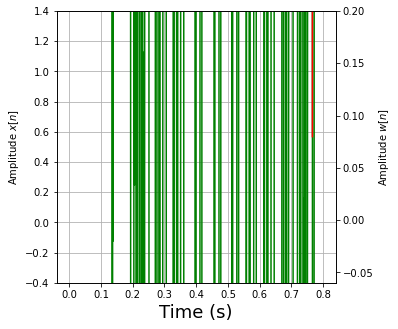

In [35]:
# compute wrapper for the previous example
w = np.sqrt(x)

# Plot
fig, ax1 = plt.subplots(figsize=(5,5))

ax2 = ax1.twinx()
ax1.plot(t[:800], x[:800], 'g-')
ax2.plot(t[:800], w[:800], 'r-')

ax1.set_xlabel('Time (s)', fontsize=18)
ax1.set_ylabel('Amplitude $x[n]$')
ax1.set_ylim([-0.4, 1.4])
ax2.set_ylabel('Amplitude $w[n]$')
ax2.set_ylim([-0.06, 0.2])
ax1.grid()
plt.show()

Let (n0-/\(lambda) <= n<=n0+/\(lambda)) the moment of occurrence of a peak of R. 
Let's define an interval n0 as a region large enough to contain the entire QRS complex, such that the start point and end point are contained within that range. The start point of the QRS complex (onset) is the first point, coming from n0 to the right, to which. Analogously, the end point of the QRS complex (offset) is the first point, coming from to the left, for which
Shown below is a function that finds the start and end of the QRS complex.